In [1]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

import gensim
from gensim.models.keyedvectors import KeyedVectors


C:\Users\PC\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\PC\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 25000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [3]:
# load dataset 
train = pd.read_csv("C:\\Users\\PC\\Desktop\\Advanced NLP\\Data\\ToxicComment\\train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

In [4]:
sentences.shape
sentences[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [5]:
# Convert the sentences into integers, Tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
print("sequences:", sequences)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
sequences[0]

[688,
 75,
 1,
 126,
 130,
 177,
 29,
 672,
 4511,
 12052,
 1116,
 86,
 331,
 51,
 2278,
 11448,
 50,
 6864,
 15,
 60,
 2756,
 148,
 7,
 2937,
 34,
 117,
 1221,
 15190,
 2825,
 4,
 45,
 59,
 244,
 1,
 365,
 31,
 1,
 38,
 27,
 143,
 73,
 3462,
 89,
 3085,
 4583,
 2273,
 985]

In [7]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

max sequence length: 1400
min sequence length: 0
median sequence length: 35


In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [9]:
word2idx

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'wikipedia': 28,
 'my': 29,
 'an': 30,
 'from': 31,
 'by': 32,
 'do': 33,
 'at': 34,
 'me': 35,
 'about': 36,
 'so': 37,
 'talk': 38,
 'what': 39,
 'can': 40,
 'there': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'no': 46,
 'would': 47,
 'one': 48,
 'like': 49,
 'just': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'any': 54,
 'been': 55,
 'should': 56,
 'more': 57,
 'we': 58,
 "don't": 59,
 'some': 60,
 'other': 61,
 'who': 62,
 'here': 63,
 'see': 64,
 'also': 65,
 'his': 66,
 'think': 67,
 'because': 68,
 'know': 69,
 'how': 70,
 'edit': 71,
 'am': 72,
 "i'm": 73,
 'people': 74,
 'why': 75,
 'up': 76,
 'only': 77,
 "it's": 78,
 'out': 79,
 'articles': 80,
 'use': 81,

In [10]:
# padding
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
data.shape

(159571, 100)

In [11]:
print("loading word2vec model…")
word2vec_model = KeyedVectors.load_word2vec_format('D:\\WordEmbeddings\\GoogleNews-vectors-negative300.bin', binary=True)

loading word2vec model…


C:\Users\PC\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [12]:
def getVector(str):
    if str in word2vec_model:
        return word2vec_model[str]
    else:
        return None
    
def isInModel(str):
    return str in word2vec_model

In [13]:
# create a weight matrix for words in training docs
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
print(num_words)
embedding_matrix = np.zeros((num_words, 300))

for word, i in word2idx.items():
    if i < num_words:
        embedding_vector = getVector(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

25000


In [14]:
# find how many words exist in word2vec original model
# to find that count how many rows are zeros in embedding matrix
print("# of word which has NOT embedding: ",np.sum(~embedding_matrix.any(1)))

# of word which has NOT embedding:  4093


In [15]:
# load pre-trained word embeddings into embedding layer
embedding_layer = Embedding(input_dim = num_words, output_dim = EMBEDDING_DIM, weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH, trainable = False)

In [51]:
# Build Model

input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

In [52]:
model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          7500000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 98, 128)           115328    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 8, 128)            49280     
__________

In [54]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 6s 49us/step - loss: 0.0803 - acc: 0.9738 - val_loss: 0.0660 - val_acc: 0.9773
Epoch 2/10
127656/127656 [==============================] - 6s 47us/step - loss: 0.0639 - acc: 0.9781 - val_loss: 0.0644 - val_acc: 0.9779
Epoch 3/10
127656/127656 [==============================] - 6s 47us/step - loss: 0.0591 - acc: 0.9792 - val_loss: 0.0670 - val_acc: 0.9776
Epoch 4/10
127656/127656 [==============================] - 6s 47us/step - loss: 0.0553 - acc: 0.9801 - val_loss: 0.0661 - val_acc: 0.9782
Epoch 5/10
127656/127656 [==============================] - 6s 48us/step - loss: 0.0516 - acc: 0.9811 - val_loss: 0.0764 - val_acc: 0.9777
Epoch 6/10
127656/127656 [==============================] - 6s 47us/step - loss: 0.0482 - acc: 0.9820 - val_loss: 0.0743 - val_acc: 0.9780
Epoch 7/10
127656/127656 [==============================] - 6s 47us/step - loss: 0.0457 - acc: 0.

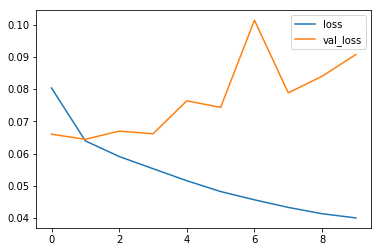

In [55]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

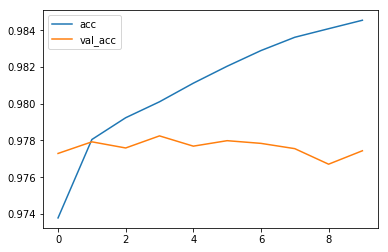

In [56]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [57]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9823256122942631


In [72]:
sample = "fucking negro :))"

In [73]:
sample_input = np.zeros((MAX_SEQUENCE_LENGTH))
i = 0

for word in sample.split(' '):
    vec = word2idx.get(word)

    if vec is not None:
        sample_input[i] = vec
        i += 1

In [74]:
sample_input = sample_input.reshape(1,100)

In [75]:
sample_input

array([[ 394., 7500.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]])

In [76]:
score = model.predict(sample_input)


In [77]:
score 

array([[0.33645144, 0.02635302, 0.24684097, 0.00398535, 0.21380708,
        0.02510348]], dtype=float32)

In [78]:
for i in range(6):
    print(possible_labels[i] + ": "+ str(score[0][i]))

toxic: 0.33645144
severe_toxic: 0.026353016
obscene: 0.24684097
threat: 0.0039853523
insult: 0.21380708
identity_hate: 0.025103478
